## Notes

This notebook only contains fitting and plotting code for the observed spectrum of HIP 65426 b as of January 2023, for the ExoGRAVITY collaboration. It does not include the code used to extract or flux calibrate this spectrum. The spectrum was extracted from one night of GRAVITY data for which there is a reliable on-axis observation, namely the Jan. 7th, 2021 observation of the system. The spectrum was extracted using the currently (as of Jan. 2023) ExoGRAVITY pipeline (see Appendix B in Nowak et al. 2020 for an outline of the data reduction steps), and flux calibrated using a BT-NextGen spectrum fit to archive photometry of the host, and scaled to match the SPHERE K1 photometry (about a factor of 0.5) of the companion. For more information on this, text for your paper, or for additional plots, contact W. Balmer :~)

This notebook assumes you have installed $\texttt{species}$, a toolkit for analyzing direct imaging observations. You can therefore change the model you fit to the observations (by default, the BT-Settl-Cifist model worked well when I was working on this target for the JWST ERS paper, but there are others listed on the species webpage), the number of live points, etc. and can save plots of the posterior of fit parameters, and the spectrum. 

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import spectres

In [2]:
# initialize species
# this notebook will work, even if you have a clean installation of the package
# see https://species.readthedocs.io/ for more
import species
species.SpeciesInit()
database = species.Database()

Initiating species v0.5.5... [DONE]
Database: /Users/bluez3303/Documents/GitHub/hip65426/species_database.hdf5
Data folder: /Users/bluez3303/Documents/GitHub/hip65426/data
Working folder: /Users/bluez3303/Documents/GitHub/hip65426
Grid interpolation method: linear


In [3]:
include_gravity = True
include_sinfoni = True
include_jwst = False
sphere_gp = True
teff_lowprior = False
teff_hiprior = False
model_choice = 'exo-rem'

filepref = 'results/'
if include_gravity:
    filepref += 'gravity_'
if include_sinfoni:
    filepref += 'sinfoni_'
if include_jwst:
    filepref += 'jwst_'
if not sphere_gp:
    filepref += 'nosphereGP_'
if teff_lowprior:
    filepref += 'tefflo_'
if teff_hiprior:
    filepref += 'teffhi_'

filepref += '{}/'.format(model_choice)
if not os.path.isdir(filepref):
    os.mkdir(filepref)
if not os.path.isdir('{}multinest/'.format(filepref)):
    os.mkdir('{}multinest/'.format(filepref))

In [4]:
# download and shape up the HIP 65426 b SPHERE spectrum
import urllib.request

urllib.request.urlretrieve(
    'https://home.strw.leidenuniv.nl/~stolker/species/spectra/hip65426_sphere_yjh.dat', 
    'data/hip65426_sphere_yjh.dat'
)

sphere_yjh = pd.read_csv('data/hip65426_sphere_yjh.dat', delim_whitespace=True, comment='#', names=['l','f','fe'])
sphere_yjh = sphere_yjh[2:]
sphere_yjh.to_csv('data/hip65426_sphere_yjh.dat', sep=' ', header=False, index=False)

# shape up the SINFONI spectrum
sinfoni = pd.read_csv('data/HIP_65426_B_final_noLSS_spec.txt', comment='#', delim_whitespace=True, usecols=[0,1,2,6], names=['l', 'f', 'fe', 'inst'])
sinfoni = sinfoni[sinfoni.inst == 'SINFONI-K']
sinfoni[['l','f','fe']].to_csv('data/sinfoni.dat', sep=' ', header=False, index=False)

In [5]:
plx = (9.3031,0.0346) # Gaia DR3

In [6]:
spectrum = {
  'SPHERE_IFU': ('data/hip65426_sphere_yjh.dat', None, 40.),
}

if include_sinfoni:
  spectrum['SINFONI-K'] =  ('data/sinfoni.dat', None, 5577.)

if include_gravity:
  spectrum['GRAVITY'] = (
    'data/HIP65426B_GRAVITYK_spectrum_fluxcal_scaled.fits', 
    'data/HIP65426B_GRAVITYK_spectrum_fluxcal_scaled.fits', 
    500.
  )

database.add_object(
  'HIP 65426 b',
  parallax=None, app_mag=None, flux_density=None,
  spectrum=spectrum, deredden=None
)

Adding object: HIP 65426 b
   - Spectrum:
      - Database tag: SPHERE_IFU
      - Filename: data/hip65426_sphere_yjh.dat
      - Data shape: (37, 3)
      - Wavelength range (um): 0.99 - 1.64
      - Mean flux (W m-2 um-1): 5.54e-17
      - Mean error (W m-2 um-1): 5.45e-18
   - Spectrum:
      - Database tag: SINFONI-K
      - Filename: data/sinfoni.dat
      - Data shape: (1979, 3)
      - Wavelength range (um): 1.97 - 2.45
      - Mean flux (W m-2 um-1): 6.26e-17
      - Mean error (W m-2 um-1): 2.97e-17
   - GRAVITY spectrum:
      - Object: HIP 65426 B
      - Database tag: GRAVITY
      - Filename: data/HIP65426B_GRAVITYK_spectrum_fluxcal_scaled.fits
      - Data shape: (192, 3)
      - Wavelength range (um): 2.05 - 2.48
      - Mean flux (W m-2 um-1): 6.48e-17
      - Mean error (W m-2 um-1): 1.60e-17
   - GRAVITY covariance matrix:
      - Object: HIP 65426 B
      - Database tag: GRAVITY
      - Filename: data/HIP65426B_GRAVITYK_spectrum_fluxcal_scaled.fits
      - Data shape

In [7]:
# add archival companion photometry
database.add_companion(name='HIP 65426 b')
objectbox = database.get_object(object_name='HIP 65426 b')

Adding object: HIP 65426 b
   - Parallax (mas) = 9.30 +/- 0.03
   - Paranal/SPHERE.IRDIS_D_H23_2:
      - Apparent magnitude = 17.94 +/- 0.05
      - Flux (W m-2 um-1) = 8.73e-17 +/- 4.02e-18
   - Paranal/SPHERE.IRDIS_D_H23_3:
      - Apparent magnitude = 17.58 +/- 0.06
      - Flux (W m-2 um-1) = 1.03e-16 +/- 5.70e-18
   - Paranal/SPHERE.IRDIS_D_K12_1:
      - Apparent magnitude = 17.01 +/- 0.09
      - Flux (W m-2 um-1) = 7.63e-17 +/- 6.33e-18
   - Paranal/SPHERE.IRDIS_D_K12_2:
      - Apparent magnitude = 16.79 +/- 0.09
      - Flux (W m-2 um-1) = 7.21e-17 +/- 5.98e-18
   - Paranal/NACO.Lp:
      - Apparent magnitude = 15.33 +/- 0.12
      - Flux (W m-2 um-1) = 3.88e-17 +/- 4.30e-18
   - Paranal/NACO.NB405:
      - Apparent magnitude = 15.23 +/- 0.22
      - Flux (W m-2 um-1) = 3.21e-17 +/- 6.55e-18
   - Paranal/NACO.Mp:
      - Apparent magnitude = 14.65 +/- 0.29
      - Flux (W m-2 um-1) = 2.99e-17 +/- 8.07e-18
Getting object: HIP 65426 b... [DONE]



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



<>:28: DeprecationWarning: invalid escape sequence '\l'
<>:29: DeprecationWarning: invalid escape sequence '\m'
<>:30: DeprecationWarning: invalid escape sequence '\m'
<>:28: DeprecationWarning: invalid escape sequence '\l'
<>:29: DeprecationWarning: invalid escape sequence '\m'
<>:30: DeprecationWarning: invalid escape sequence '\m'
/var/folders/y8/lw5f1dcj04g4txq4y2znyc200000gn/T/ipykernel_47506/1231869645.py:28: DeprecationWarning: invalid escape sequence '\l'
  ax[1].set_xlabel('$\lambda$ [$\mu$m]')
/var/folders/y8/lw5f1dcj04g4txq4y2znyc200000gn/T/ipykernel_47506/1231869645.py:29: DeprecationWarning: invalid escape sequence '\m'
  ax[0].set_ylabel('flux [W m$^{-2}$ $\mu$m$^{-1}$]')
/var/folders/y8/lw5f1dcj04g4txq4y2znyc200000gn/T/ipykernel_47506/1231869645.py:30: DeprecationWarning: invalid escape sequence '\m'
  ax[1].set_ylabel('flux [W m$^{-2}$ $\mu$m$^{-1}$]')


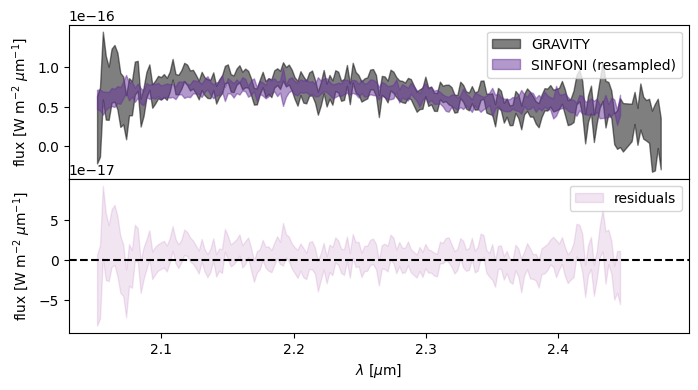

In [8]:
if include_gravity and include_sinfoni:

    # make a plot comparing the SINFONI and GRAVITY spectra
    gravity_spectrum = objectbox.spectrum['GRAVITY'][0]
    sinfoni_spectrum = objectbox.spectrum['SINFONI-K'][0]

    fig, ax = plt.subplots(2, 1, figsize=(8,4), sharex=True)
    plt.subplots_adjust(hspace=0)
    offset = 0

    ax[0].fill_between(gravity_spectrum[:,0], offset + gravity_spectrum[:,1] + gravity_spectrum[:,2], offset + gravity_spectrum[:,1] - gravity_spectrum[:,2], color='k', alpha=0.5, label='GRAVITY')

    # downsample the SINFONI data to directly compare with GRAVITY
    sinfoni_equivalent_flux = np.zeros(len(gravity_spectrum))

    gravity_wavelength = gravity_spectrum[:,0]
    gravity_dlambda = gravity_wavelength[1] - gravity_wavelength[0]
    sinfoni_dlambda = sinfoni_spectrum[1,0] - sinfoni_spectrum[0,0]

    sinfoni_equivalent_flux, sinfoni_equivalent_flux_errs = spectres.spectres(gravity_wavelength, sinfoni_spectrum[:,0], sinfoni_spectrum[:,1], sinfoni_spectrum[:,2], fill=0)

    ax[0].fill_between(
        gravity_wavelength[sinfoni_equivalent_flux>0], 
        offset + sinfoni_equivalent_flux[sinfoni_equivalent_flux>0] + sinfoni_equivalent_flux_errs[sinfoni_equivalent_flux>0],
        offset + sinfoni_equivalent_flux[sinfoni_equivalent_flux>0] - sinfoni_equivalent_flux_errs[sinfoni_equivalent_flux>0], color='rebeccapurple', alpha=0.5, label='SINFONI (resampled)'
    )

    ax[1].set_xlabel('$\lambda$ [$\mu$m]')
    ax[0].set_ylabel('flux [W m$^{-2}$ $\mu$m$^{-1}$]')
    ax[1].set_ylabel('flux [W m$^{-2}$ $\mu$m$^{-1}$]')

    ax[0].set_yticks([0, 5e-17, 10e-17])

    ax[1].set_yticks([-5e-17, 0, 5e-17])
    ax[0].legend()

    residuals = gravity_spectrum[:,1][sinfoni_equivalent_flux>0] - sinfoni_equivalent_flux[sinfoni_equivalent_flux>0]
    residual_errors = np.sqrt(gravity_spectrum[:,2][sinfoni_equivalent_flux>0]**2 + sinfoni_equivalent_flux_errs[sinfoni_equivalent_flux>0]**2)

    ax[1].axhline(0, color='k', ls='--')
    ax[1].fill_between(
        gravity_wavelength[sinfoni_equivalent_flux>0],
        residuals + residual_errors, residuals - residual_errors, color='purple', alpha=0.1, label='residuals'
    )
    ax[1].legend()
    plt.savefig('results/plots/gravity_vs_sinfoni.png', dpi=250)

In [9]:
database.add_object(
        'HIP 65426 b',
        parallax=plx,
        app_mag={ # Carter et al. ERS vegamag
                'JWST/NIRCAM.F250M':(17.163, 0.140),
                'JWST/NIRCAM.F300M':(16.827, 0.117),
                'JWST/NIRCAM.F356W':(16.067, 0.115),
                'JWST/NIRCAM.F410M':(15.781, 0.120),
                'JWST/NIRCAM.F444W':(15.701, 0.126),
                'JWST/MIRI.F1140C':(15.357, 0.093),
                'JWST/MIRI.F1550C':(15.197, 0.177)
        },
        spectrum=None, deredden=None)

if not include_jwst:
        database.delete_data('objects/HIP 65426 b/JWST/MIRI.F1550C')
        database.delete_data('objects/HIP 65426 b/JWST/MIRI.F1140C')
        database.delete_data('objects/HIP 65426 b/JWST/NIRCAM.F444W')
        database.delete_data('objects/HIP 65426 b/JWST/NIRCAM.F410M')
        database.delete_data('objects/HIP 65426 b/JWST/NIRCAM.F356W')
        database.delete_data('objects/HIP 65426 b/JWST/NIRCAM.F300M')
        database.delete_data('objects/HIP 65426 b/JWST/NIRCAM.F250M')


Adding object: HIP 65426 b
   - Parallax (mas) = 9.30 +/- 0.03
   - JWST/NIRCAM.F250M:
      - Apparent magnitude = 17.16 +/- 0.14
      - Flux (W m-2 um-1) = 3.45e-17 +/- 4.46e-18
   - JWST/NIRCAM.F300M:
      - Apparent magnitude = 16.83 +/- 0.12
      - Flux (W m-2 um-1) = 2.42e-17 +/- 2.61e-18
   - JWST/NIRCAM.F356W:
      - Apparent magnitude = 16.07 +/- 0.12
      - Flux (W m-2 um-1) = 2.51e-17 +/- 2.66e-18
   - JWST/NIRCAM.F410M:
      - Apparent magnitude = 15.78 +/- 0.12
      - Flux (W m-2 um-1) = 1.92e-17 +/- 2.13e-18
   - JWST/NIRCAM.F444W:
      - Apparent magnitude = 15.70 +/- 0.13
      - Flux (W m-2 um-1) = 1.57e-17 +/- 1.82e-18
   - JWST/MIRI.F1140C:
      - Apparent magnitude = 15.36 +/- 0.09
      - Flux (W m-2 um-1) = 5.25e-19 +/- 4.50e-20
   - JWST/MIRI.F1550C:
      - Apparent magnitude = 15.20 +/- 0.18
      - Flux (W m-2 um-1) = 1.74e-19 +/- 2.85e-20
Deleting data: objects/HIP 65426 b/JWST/MIRI.F1550C... [DONE]
Deleting data: objects/HIP 65426 b/JWST/MIRI.F1140C

In [10]:
database.add_model(model=model_choice, teff_range=(1200., 2000.))

Unpacking Exo-REM model spectra (706 MB)... [DONE]
Please cite Charney et al. (2018) when using Exo-REM in a publication
Reference URL: https://ui.adsabs.harvard.edu/abs/2018ApJ...854..172C/abstract
Wavelength range (um) = 0.9 - 5
Spectral resolution = 10000
Teff range (K) = 1200.0 - 2000.0
Adding Exo-REM model spectra... [DONE]                                              
Grid points stored in the database:
   - Teff = [1200. 1250. 1300. 1350. 1400. 1450. 1500. 1550. 1600. 1650. 1700. 1750.
 1800. 1850. 1900. 1950. 2000.]
   - log(g) = [3.5 4.  4.5 5. ]
   - [Fe/H] = [-0.5  0.   0.5]
   - C/O = [0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85]
Number of grid points per parameter:
   - teff: 17
   - logg: 4
   - feh: 3
   - c_o_ratio: 12


/Users/bluez3303/Documents/GitHub/species/species/util/data_util.py:380: RuntimeWarning: divide by zero encountered in log10
  flux = np.log10(flux)


Fix missing grid points with a linear interpolation:
   - teff = 1200.0, logg = 3.5, feh = -0.5, c_o_ratio = 0.8
   - teff = 1200.0, logg = 3.5, feh = -0.5, c_o_ratio = 0.85
   - teff = 1200.0, logg = 3.5, feh = 0.0, c_o_ratio = 0.8
   - teff = 1200.0, logg = 3.5, feh = 0.0, c_o_ratio = 0.85
   - teff = 1200.0, logg = 3.5, feh = 0.5, c_o_ratio = 0.7
   - teff = 1200.0, logg = 3.5, feh = 0.5, c_o_ratio = 0.75
   - teff = 1200.0, logg = 3.5, feh = 0.5, c_o_ratio = 0.8
   - teff = 1200.0, logg = 3.5, feh = 0.5, c_o_ratio = 0.85
   - teff = 1200.0, logg = 4.0, feh = -0.5, c_o_ratio = 0.8
   - teff = 1200.0, logg = 4.0, feh = -0.5, c_o_ratio = 0.85
   - teff = 1200.0, logg = 4.0, feh = 0.0, c_o_ratio = 0.8
   - teff = 1200.0, logg = 4.0, feh = 0.0, c_o_ratio = 0.85
   - teff = 1200.0, logg = 4.0, feh = 0.5, c_o_ratio = 0.8
   - teff = 1200.0, logg = 4.0, feh = 0.5, c_o_ratio = 0.85
   - teff = 1200.0, logg = 4.5, feh = -0.5, c_o_ratio = 0.3
   - teff = 1200.0, logg = 4.5, feh = 0.0, c_o_rat

In [11]:
inc_phot = [
        'Paranal/SPHERE.IRDIS_D_H23_2',
        'Paranal/SPHERE.IRDIS_D_H23_3',
        'Paranal/SPHERE.IRDIS_D_K12_1',
        'Paranal/SPHERE.IRDIS_D_K12_2',
        'Paranal/NACO.Lp',
        'Paranal/NACO.NB405',
        'Paranal/NACO.Mp'
]

if include_jwst:
    inc_phot += [
        'JWST/NIRCAM.F250M',
        'JWST/NIRCAM.F300M',
        'JWST/NIRCAM.F356W',
        'JWST/NIRCAM.F410M',
        'JWST/NIRCAM.F444W',
        'JWST/MIRI.F1140C',
        'JWST/MIRI.F1550C'
    ]

if sphere_gp:
    fit_corr=['SPHERE_IFU']
else:
    fit_corr=[]
if teff_lowprior:
    teff_bounds = (1200., 1500.)
elif teff_hiprior:
    teff_bounds = (1500., 2000.)
else:
    teff_bounds = (1200., 2000.)


bounds = {
    'teff': teff_bounds, 
    # 'SPHERE_IFU':(None, None, (0, 50))
}
if include_gravity:
    bounds['GRAVITY'] = (None, None, (0,50))
if include_sinfoni:
    bounds['SINFONI-K'] = (None, None, (0,50))
fit = species.FitModel(
        object_name='HIP 65426 b',
        model=model_choice,
        bounds=bounds,
        inc_phot=inc_phot,
        inc_spec=True,
        fit_corr=fit_corr,
        weights=None
)


Getting object: HIP 65426 b... [DONE]
Interpolating Paranal/SPHERE.IRDIS_D_H23_2... [DONE]
Interpolating Paranal/SPHERE.IRDIS_D_H23_3... [DONE]
Interpolating Paranal/SPHERE.IRDIS_D_K12_1... [DONE]
Interpolating Paranal/SPHERE.IRDIS_D_K12_2... [DONE]
Interpolating Paranal/NACO.Lp... [DONE]
Interpolating Paranal/NACO.NB405... [DONE]
Interpolating Paranal/NACO.Mp... [DONE]
Interpolating GRAVITY... [DONE]
Interpolating SINFONI-K... [DONE]
Interpolating SPHERE_IFU... [DONE]
Fitting 10 parameters:
   - teff
   - logg
   - feh
   - c_o_ratio
   - radius
   - parallax
   - corr_len_SPHERE_IFU
   - corr_amp_SPHERE_IFU
   - radvel_GRAVITY
   - radvel_SINFONI-K
Prior boundaries:
   - teff = (1200.0, 2000.0)
   - logg = (3.5, 5.0)
   - feh = (-0.5, 0.5)
   - c_o_ratio = (0.3, 0.85)
   - radius = (0.5, 5.0)
   - corr_len_SPHERE_IFU = (-3.0, 0.0)
   - corr_amp_SPHERE_IFU = (0.0, 1.0)
   - radvel_GRAVITY = (0, 50)
   - radvel_SINFONI-K = (0, 50)
Weights for the log-likelihood function:
   - GRAVITY =

In [12]:
tag='hip65426_{}'.format(filepref.split('/')[1])

In [13]:
fit.run_multinest(tag=tag,
                  n_live_points=1000,
                  output='{}multinest/'.format(filepref),
                #   prior={'mass': (7.1, 1.1)} # prior from evol model, can include or disregard
                 )

Running nested sampling with MultiNest...
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =   10
 *****************************************************


/Users/bluez3303/miniconda3/envs/multinest/lib/python3.10/site-packages/pymultinest/run.py:208: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  nargs = len(inspect.getargspec(LogLikelihood).args) - inspect.ismethod(LogLikelihood)



 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the ed

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 136;
tau: [412.31525199]


Integrated autocorrelation time:
   - teff: 3.19
   - logg: 23.79
   - feh: 2.39
   - c_o_ratio: 1.44
   - radius: 412.32
   - parallax: 5.19
   - corr_len_SPHERE_IFU: 1.86
   - corr_amp_SPHERE_IFU: 1.71
   - radvel_GRAVITY: 5.40
   - radvel_SINFONI-K: 1.60


In [14]:
post = species.plot_posterior(tag=tag,
                       offset=(-0.3 , -0.3),
                       # title_fmt=['.0f', '.2f', '.2f', '.2f', '.2f', '.2f', '.3f', '.1f'],
                       inc_luminosity=True,
                       inc_mass=True,
                       output='{}post.png'.format(filepref))

Median sample:
   - teff = 1.35e+03
   - logg = 3.52e+00
   - feh = -1.49e-03
   - c_o_ratio = 5.98e-01
   - radius = 1.46e+00
   - parallax = 9.30e+00
   - corr_len_SPHERE_IFU = -1.22e+00
   - corr_amp_SPHERE_IFU = 5.27e-01
   - radvel_GRAVITY = 2.24e+01
   - radvel_SINFONI-K = 1.75e+01
Plotting the posterior: results/gravity_sinfoni_exo-rem/post.png... [DONE]


In [15]:
samples = database.get_mcmc_spectra(tag=tag,
                                    random=30,
                                    wavel_range=None,
                                    spec_res=500.)

best = database.get_median_sample(tag=tag)

read_model = species.ReadModel(model=model_choice,
                               wavel_range=None)

modelbox = read_model.get_model(model_param=best,
                                spec_res=500.,
                                smooth=True)

objectbox = database.get_object(object_name='HIP 65426 b',
                                inc_phot=True,
                                inc_spec=True)

objectbox = species.update_spectra(objectbox=objectbox,
                                   model_param=best)

residuals = species.get_residuals(datatype='model',
                                  spectrum=model_choice,
                                  parameters=best,
                                  objectbox=objectbox,
                                  inc_phot=True,
                                  inc_spec=True)

synphot = species.multi_photometry(datatype='model',
                                   spectrum=model_choice,
                                   filters=objectbox.filters,
                                   parameters=best)

species.plot_spectrum(boxes=[samples, modelbox, objectbox, synphot],
                      filters=objectbox.filters,
                      residuals=residuals,
                      plot_kwargs=[{'ls': '-', 'lw': 0.2, 'color': 'gray'},
                                   {'ls': '-', 'lw': 1., 'color': 'black'},
                                   {'GRAVITY': {'marker': '.', 'ms': 5., 'mew': 0., 'color': 'seagreen', 'ls': 'none', 'alpha': 0.3, 'label': 'GRAVITY'},
                                    'SINFONI-K': {'marker': '.', 'ms': 5., 'mew': 0., 'color': 'seagreen', 'ls': 'none', 'alpha': 0.3, 'label': 'SINFONI-K'},
                                    'SPHERE_IFU': {'marker': 's', 'ms': 2., 'mew': 0., 'color': 'cornflowerblue', 'ls': '', 'alpha': 1, 'label': 'SPHERE IFU'},
                                    'Paranal/NACO.Lp': {'marker': 's', 'ms': 5., 'color': 'tomato', 'ls': 'none', 'label':'NACO'},
                                    'Paranal/NACO.NB405': {'marker': 's', 'markersize': 5., 'color': 'tomato', 'ls': 'none'},
                                    'Paranal/NACO.Mp': {'marker': 's', 'markersize': 5., 'color': 'tomato', 'ls': 'none'},
                                    'JWST/NIRCAM.F250M': {'marker': 's', 'markersize': 5., 'color': 'xkcd:mustard', 'ls': 'none', 'label':'JWST/NIRCAM'},
                                    'JWST/NIRCAM.F300M': {'marker': 's', 'markersize': 5., 'color': 'xkcd:mustard', 'ls': 'none'},
                                    'JWST/NIRCAM.F356W': {'marker': 's', 'markersize': 5., 'color': 'xkcd:mustard', 'ls': 'none'},
                                    'JWST/NIRCAM.F410M': {'marker': 's', 'markersize': 5., 'color': 'xkcd:mustard', 'ls': 'none'},
                                    'JWST/NIRCAM.F444W': {'marker': 's', 'markersize': 5., 'color': 'xkcd:mustard', 'ls': 'none'},
                                    'JWST/MIRI.F1140C': {'marker': 's', 'markersize': 5., 'color': 'purple', 'ls': 'none', 'label':'JWST/MIRI'},
                                    'JWST/MIRI.F1550C': {'marker': 's', 'markersize': 5., 'color': 'purple', 'ls': 'none'},
                                    'Paranal/SPHERE.IRDIS_D_H23_2': {'marker': '^', 'ms': 7., 'mew': 0., 'color': 'hotpink', 'ls': '', 'alpha': 1, 'label': 'SPHERE'},
                                    'Paranal/SPHERE.IRDIS_D_H23_3': {'marker': '^', 'ms': 7., 'mew': 0., 'color': 'hotpink', 'ls': '', 'alpha': 1},
                                    'Paranal/SPHERE.IRDIS_D_K12_1': {'marker': '^', 'ms': 7., 'mew': 0., 'color': 'hotpink', 'ls': '', 'alpha': 1},
                                    'Paranal/SPHERE.IRDIS_D_K12_2': {'marker': '^', 'ms': 7., 'mew': 0., 'color': 'hotpink', 'ls': '', 'alpha': 1},
                                   },
                                    None],
                      xlim=(0.8, 10.),
                      # ylim=(1.15e-20, 2e-16),
                      ylim_res=(-6., 6.),
                      scale=('log', 'linear'),
                      offset=(-0.4, -0.05),
                      legend=[{'loc': 'lower left', 'frameon': False, 'fontsize': 11.},
                              {'loc': 'upper right', 'frameon': False, 'fontsize': 12.}],
                      figsize=(12., 6.),
                      quantity='flux density',
                      output=filepref+'HIP65426b-SED.pdf'
                     )

Getting MCMC spectra:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/bluez3303/Documents/GitHub/species/species/read/read_model.py:721: UserWarning: The 'radvel_GRAVITY' parameter is not required by 'exo-rem' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh', 'c_o_ratio'].
  warnings.warn(
/Users/bluez3303/Documents/GitHub/species/species/read/read_model.py:721: UserWarning: The 'radvel_SINFONI-K' parameter is not required by 'exo-rem' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh', 'c_o_ratio'].
  warnings.warn(
/Users/bluez3303/Documents/GitHub/species/species/read/read_model.py:721: UserWarning: The 'corr_len_SPHERE_IFU' parameter is not required by 'exo-rem' so the parameter will be ignored. The mandatory parameters are ['teff', 'logg', 'feh', 'c_o_ratio'].
  warnings.warn(
/Users/bluez3303/Documents/GitHub/species/species/read/read_model.py:721: UserWarning: The 'corr_amp_SPHERE_IFU' parameter is not required by 'exo-rem' so the parameter will be ignored. The mandator

Getting object: HIP 65426 b... [DONE]
Calculating synthetic photometry...

/Users/bluez3303/Documents/GitHub/species/species/util/read_util.py:176: DeprecationWarning: The update_spectra function is deprecated and will be removed in a future release. Please use the update_objectbox function instead.
  warnings.warn(


 [DONE]
Calculating residuals... [DONE]
Residuals (sigma):
   - Paranal/NACO.Lp: 3.35
   - Paranal/NACO.Mp: 2.40
   - Paranal/NACO.NB405: 1.68
   - Paranal/SPHERE.IRDIS_D_H23_2: 1.76
   - Paranal/SPHERE.IRDIS_D_H23_3: 0.68
   - Paranal/SPHERE.IRDIS_D_K12_1: 0.78
   - Paranal/SPHERE.IRDIS_D_K12_2: -0.15
   - GRAVITY: min: -1.70, max: 2.48
   - SINFONI-K: min: -1.27, max: 2.45
   - SPHERE_IFU: min: -2.32, max: 2.35
Reduced chi2 = 0.18
Number of degrees of freedom = 2205
Calculating synthetic photometry... [DONE]
Plotting spectrum: results/gravity_sinfoni_exo-rem/HIP65426b-SED.pdf... [DONE]
